{/* cspell:ignore edgecolor */}
# Scaling Periodic Boundary Problems with Circuit Cutting
*Usage estimate: 2 minutes on IBM Brisbane (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

In this notebook, we consider the simulation of a periodic chain of qubits where there is two qubit operation between every two adjacent qubits, including the first and the last ones. Periodic chains are often found in physics and chemistry problems such as Ising models, molecular simulation, etc.

Current IBM Quantum devices are planar. It is possible to embed some periodic chains on the topology directly where the first and last qubits are neighbors. However, for big enough problems, the first and last qubits can be far apart, thus requiring many SWAP gates for the 2-qubit operation between these two qubits. Such a periodic boundary problem has been studied in <a href="https://arxiv.org/abs/2402.17833">this paper</a>.

In this notebook we show the usage of circuit cutting to deal with such a utility scale periodic chain problem where the first and last qubits are not neighbors. Cutting this long range connectivity avoids the extra SWAP gates at the cost of executing multiple instances of the circuit, and some classical postprocessing. In summary, cutting can be incorporated to logically calculate the long distance 2-qubit operations. In other words, this approach leads to an effective increase in the connectivity of the coupling map, thus leading to a fewer number of SWAP gates.

Note that there are two types of cuts - cutting the wire of a circuit (called `wire cutting`), or replacing a 2-qubit gate with multiple single qubit operations (called `gate cutting`). In this notebook, we shall focus on gate cutting. For more details on gate cutting, refer to the <a href="https://qiskit.github.io/qiskit-addon-cutting/explanation/index.html">explanatory materials</a> in `qiskit-addon-cutting`, and the corresponding references. For more details on wire cutting, refer to <a href="https://learning.quantum.ibm.com/tutorial/wire-cutting-to-improve-performance">this notebook</a>, or the tutorials in <a href='https://qiskit.github.io/qiskit-addon-cutting/tutorials/index.html'>qiskit-addon-cutting</a>.

## Requirements

Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK 1.2 or later (`pip install qiskit`)
- Qiskit Runtime 0.3 or later (`pip install qiskit-ibm-runtime`)
- Circuit cutting Qiskit addon 0.9.0 or later (`pip install qiskit-addon-cutting`)

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    BasisTranslator,
    Optimize1qGatesDecomposition,
)
from qiskit.circuit.equivalence_library import (
    SessionEquivalenceLibrary as sel,
)
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal

from qiskit_addon_cutting import (
    cut_gates,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2, SamplerOptions, Batch

## Step 1: Map classical inputs to a quantum problem

Here, we'll generate a TwoLocal circuit and define some observables.

<ul>
    <li>Input: Parameters to create a circuit</li>
    <li>Output: Abstract circuit and observables</li>
</ul>

We consider a hardware-efficient `entangler map` for the TwoLocal circuit with periodic connectivity between the last and the first qubits of the `entangler map`. This long range interaction can lead to extra SWAP gates during transpilation, thus increasing the depth of the circuit.

#### Select backend and initial layout

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

For this notebook we shall consider a 109 qubit periodic 1D chain, which is the longest 1D chain in the topology of a 127 qubit IBM Quantum device. It is not possible to arrange a 109 qubit periodic chain on a 127 qubit device such that the first and last qubits are neighbors without incorporating extra SWAP gates.

In [2]:
init_layout = [
    13,
    12,
    11,
    10,
    9,
    8,
    7,
    6,
    5,
    4,
    3,
    2,
    1,
    0,
    14,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    36,
    51,
    50,
    49,
    48,
    47,
    46,
    45,
    44,
    43,
    42,
    41,
    40,
    39,
    38,
    37,
    52,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    74,
    89,
    88,
    87,
    86,
    85,
    84,
    83,
    82,
    81,
    80,
    79,
    78,
    77,
    76,
    75,
    90,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    106,
    107,
    108,
    112,
    126,
    125,
    124,
    123,
    122,
    121,
    120,
    119,
    118,
    117,
    116,
    115,
    114,
    113,
]

# the number of qubits in the circuit is governed by the length of the initial layout
num_qubits = len(init_layout)
num_qubits

109

#### Build the entangler map for the TwoLocal circuit

In [3]:
coupling_map = [(i, i + 1) for i in range(0, len(init_layout) - 1)]
coupling_map.append(
    (len(init_layout) - 1, 0)
)  # adding in the periodic connectivity

TwoLocal circuit allows the repetition of the `rotation_blocks` and the `entangler map` multiple times. For this case, the number of repetitions determine the number of periodic gates that need to be cut. Since the sampling overhead increases exponentially with the number of cuts (refer to <a href="https://learning.quantum.ibm.com/tutorial/wire-cutting-to-improve-performance">this notebook</a> for more details), we shall fix the number of repetitions to 2 in this notebook.

In [4]:
num_reps = 2
entangler_map = []

for even_edge in coupling_map[0 : len(coupling_map) : 2]:
    entangler_map.append(even_edge)

for odd_edge in coupling_map[1 : len(coupling_map) : 2]:
    entangler_map.append(odd_edge)

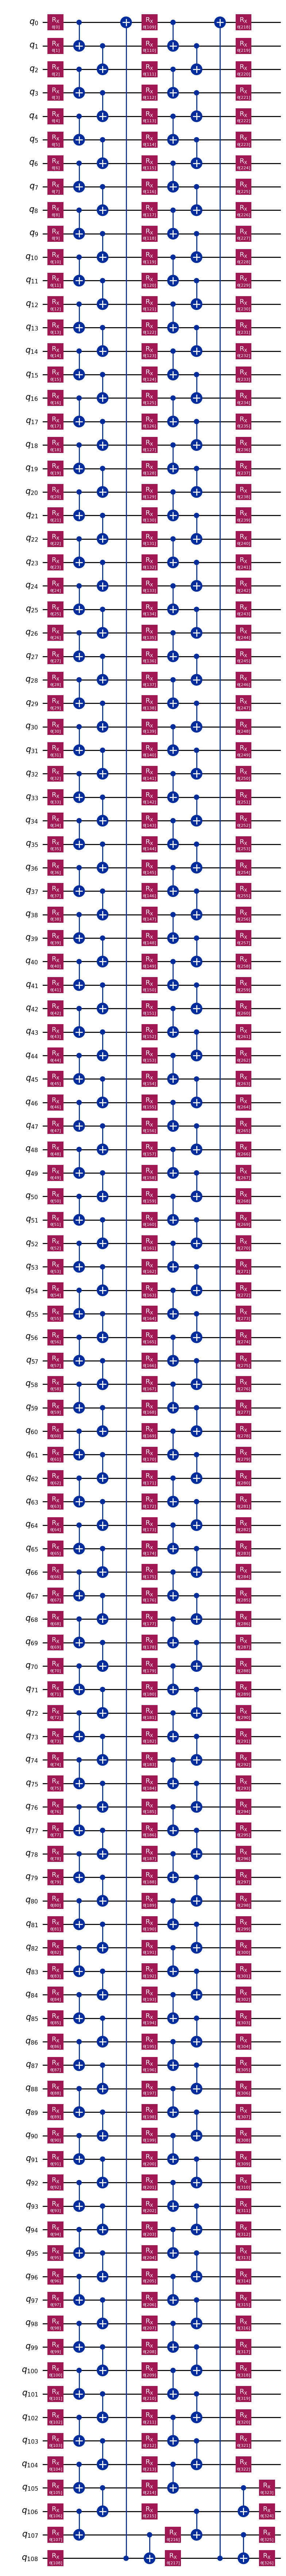

In [ ]:
ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks="rx",
    entanglement_blocks="cx",
    entanglement=entangler_map,
    reps=num_reps,
).decompose()
ansatz.draw("mpl", fold=-1)

In order to verify the quality of the outcome using circuit cutting, we need to know the ideal outcome. The current circuit of choice is beyond brute force classical simulation. Therefore, we fix the parameters to the circuit carefully to make it clifford.

We shall assign the parameter value $0$ for the first two layers of `Rx` gates, and the value $\pi$ for the last layer. This ensures that the ideal outcome of this circuit is $|1\rangle^{\otimes n}$, $n$ being the number of qubits. Therefore, the expectation values of $\langle Z_i \rangle$ and $\langle Z_i Z_{i+1} \rangle$, where $i$ is the index of the qubit, are $-1$ and $+1$ respectively.

In [ ]:
params_last_layer = [np.pi] * ansatz.num_qubits
params = [0] * (ansatz.num_parameters - ansatz.num_qubits)
params.extend(params_last_layer)

ansatz.assign_parameters(params, inplace=True)

#### Select observables

To quantify the benefits of gate cutting we measure the expectation values of the observables $\frac{1}{n}\sum_{i=1}^n \langle Z_i \rangle$ and $\frac{1}{n-1}\sum_{i=1}^{n-1} \langle Z_i Z_{i+1} \rangle$. As discussed before, the ideal expectation values are $-1$ and $+1$ respectively.

In [ ]:
observables = []

for i in range(num_qubits):
    obs = "I" * (i) + "Z" + "I" * (num_qubits - i - 1)
    observables.append(obs)

for i in range(num_qubits):
    if i == num_qubits - 1:
        obs = "Z" + "I" * (num_qubits - 2) + "Z"
    else:
        obs = "I" * i + "ZZ" + "I" * (num_qubits - i - 2)
    observables.append(obs)

observables = SparsePauliOp(observables)
paulis = observables.paulis
coeffs = observables.coeffs

## Step 2: Optimize problem for quantum hardware execution

<ul>
    <li>Input: Abstract circuit and observables</li>
    <li>Output: Target circuit and observables produced by cutting long range gates</li>
</ul>

#### Transpile the circuit

Note that the circuit can be transpiled at this stage, or after cutting. If we transpile after cutting, that will require us to transpile each of the subexperiments generated due to the sampling overhead. Therefore, it is more prudent to transpile at this stage to reduce the overhead of transpilation.

However, if transpilation is done at this stage with native hardware connectivity, the transpiler will append multiple SWAP gates to place the periodic 2-qubit operation – obfuscating the benefits of circuit cutting. To avoid this problem we can leverage that we know the exact gates that needs to be cut. Specifically, we can create a virtual coupling map by adding virtual connections between far away qubits to accommodate these periodic 2-qubit gates. This will ensure that the circuit can be transpiled at this stage without incorporating the extra SWAP gates.

In [8]:
coupling_map = backend.configuration().coupling_map

# create a virtual coupling map with long range connectivity
virtual_coupling_map = coupling_map.copy()
virtual_coupling_map.append([init_layout[-1], init_layout[0]])
virtual_coupling_map.append([init_layout[0], init_layout[-1]])

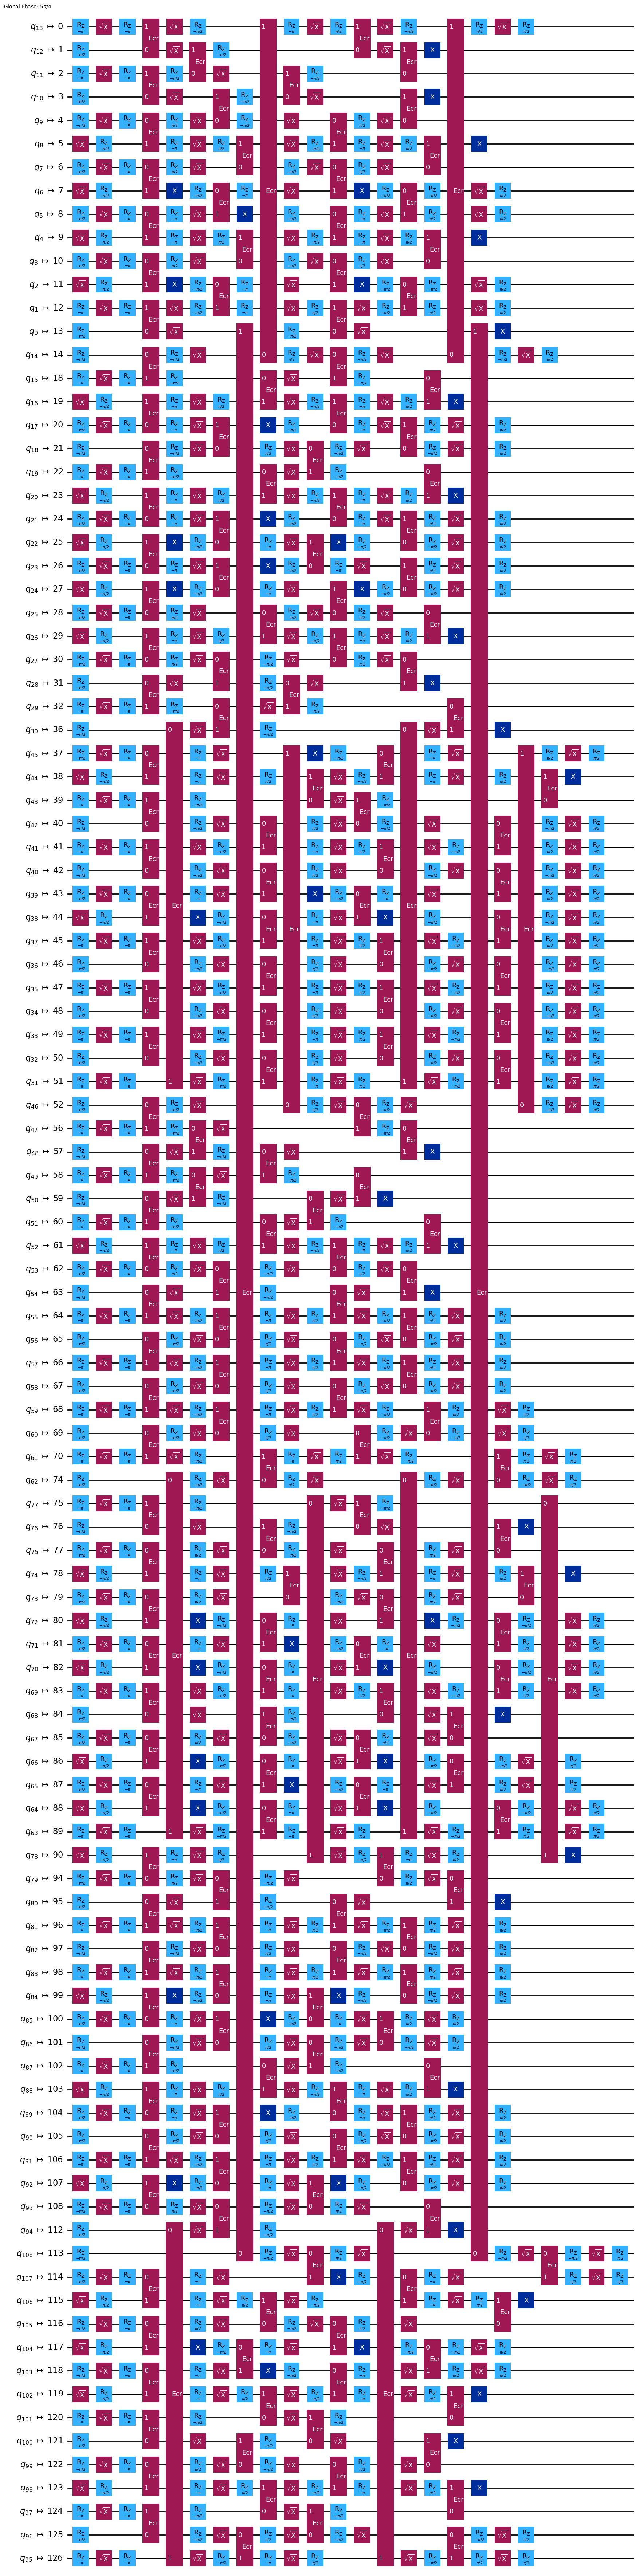

In [ ]:
pm_virtual = generate_preset_pass_manager(
    optimization_level=1,
    coupling_map=virtual_coupling_map,
    initial_layout=init_layout,
    basis_gates=backend.configuration().basis_gates,
)

virtual_mapped_circuit = pm_virtual.run(ansatz)
virtual_mapped_circuit.draw("mpl", fold=-1, idle_wires=False)

#### Cut the long range periodic connectivities

Now we cut the gates in the transpiled circuit. Note that the 2-qubit gates that need to be cut are the ones connecting the last and the first qubits of the layout.

In [ ]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(virtual_mapped_circuit.data)
    if {virtual_mapped_circuit.find_bit(q)[0] for q in instruction.qubits}
    == {init_layout[-1], init_layout[0]}
]

We shall apply the layout of the transpiled circuit to the observable.

In [12]:
trans_observables = observables.apply_layout(virtual_mapped_circuit.layout)

Finally the subexperiments are generated by sampling over different measurement and preparation bases.

In [ ]:
qpd_circuit, bases = cut_gates(virtual_mapped_circuit, cut_indices)
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit,
    observables=trans_observables.paulis,
    num_samples=np.inf,
)

Note that cutting the long range interactions leads to the execution of multiple samples of the circuit that differ in the measurement and preparation bases. More information about this can be found in <a href='https://arxiv.org/abs/1909.07534'>Constructing a virtual two-qubit gate by sampling single-qubit operations</a> and <a href='https://arxiv.org/abs/2312.11638'>Cutting circuits with multiple two-qubit unitaries</a>.

The number of periodic gates to be cut is equal to the number of repetitions of the `TwoLocal` layer, defined as `num_reps` above. The sampling overhead of gate cutting is 6. Therefore, the total number of subexperiments will be $6^{num\_reps}$.

In [14]:
print(f"Number of subexperiments is {len(subexperiments)} = 6**{num_reps}")

Number of subexperiments is 36 = 6**2


#### Transpile the subexperiments

At this point, the subexperiments contains circuits with some 1-qubit gates that are not in the basis gate set. This is because the cut qubits are measured in different basis, and the rotation gates used for this does not necessarily belong to the basis gate set. For example, measurement in X basis implies applying a Hadamard gate before the usual measurement in Z basis. But Hadamard is not a part of the basis gate set.

Instead of applying the entire transpilation process on each of the circuits in the subexperiments, we can use specific transpilation passes. Refer to <a href="https://docs.quantum.ibm.com/api/qiskit/transpiler_passes">this documentation</a> for a detailed description of all the available transpilation passes.

We shall apply ```BasisTranslator``` and then ```Optimize1qGatesDecomposition``` passes to ensure that all the gates in these circuits belong to the basis gate set. Using these two passes is faster than the entire transpilation process, since other steps such as routing, initial layout selection etc. are not performed again.

In [ ]:
pass_ = PassManager(
    [Optimize1qGatesDecomposition(basis=backend.configuration().basis_gates)]
)

subexperiments = pass_.run(
    [
        dag_to_circuit(
            BasisTranslator(sel, target_basis=backend.basis_gates).run(
                circuit_to_dag(circ)
            )
        )
        for circ in subexperiments
    ]
)

## Step 3: Execute using Qiskit primitives

<ul>
    <li>Input: Target circuits</li>
    <li>Output: Quasi-probability distributions</li>
</ul>

We use a `SamplerV2` primitive for execution of the cut circuits. We disable `dynamical decoupling` and `twirling` so that any improvement we obtain in the result will solely be due to effective application of gate cutting for this type of circuit.

In [ ]:
options = SamplerOptions()
options.default_shots = 10000
options.dynamical_decoupling.enable = False
options.twirling.enable_gates = False
options.twirling.enable_measure = False

Now we shall submit the jobs using batch mode.

In [ ]:
with Batch(backend=backend) as batch:
    sampler = SamplerV2(options=options)
    cut_job = sampler.run(subexperiments)

print(f"Job ID {cut_job.job_id()}")

Job ID cwxf7wq60bqg008pvt8g


In [18]:
result = cut_job.result()

## Step 4: Post-process and return result in desired classical format
<ul>
    <li>Input: Quasi-probability distributions</li>
    <li>Output: Reconstructed expectation values</li>
</ul>

In [ ]:
reconstructed_expvals = reconstruct_expectation_values(
    result,
    coefficients,
    paulis,
)

We now calculate the average of weight-1 and weight-2 Z-type observables.

In [20]:
cut_weight_1 = np.mean(reconstructed_expvals[:num_qubits])
cut_weight_2 = np.mean(reconstructed_expvals[num_qubits:])

print(f"Average of weight-1 expectation values is {cut_weight_1}")
print(f"Average of weight-2 expectation values is {cut_weight_2}")

Average of weight-1 expectation values is -0.741733944954063
Average of weight-2 expectation values is 0.6968862385320495


### Cross Verify: Obtain uncut expectation value

It is useful to cross-verify the advantage of the circuit cutting technique against uncut. Here we shall compute the expectation values without cutting the circuit. Note that such an uncut circuit will suffer from a large number of SWAP gates required to implement the 2-qubit operation between the first and the last qubits. We shall use the `sampled_expectation_value` function to obtain the expectation values of the uncut circuit after obtaining the probability distribution via `SamplerV2`. This allows a homogenous usage of primitive over all the instances. However, note that we could have used `EstimatorV2` as well to directly compute the expectation values.

In [23]:
if ansatz.num_clbits == 0:
    ansatz.measure_all()

pm_uncut = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=init_layout
)

transpiled_circuit = pm_uncut.run(ansatz)

In [24]:
sampler = SamplerV2(mode=backend, options=options)
uncut_job = sampler.run([transpiled_circuit])

In [25]:
uncut_job_id = uncut_job.job_id()
print(f"The job id for the uncut clifford circuit is {uncut_job_id}")

The job id for the uncut clifford circuit is cwxfads2ac5g008jhe7g


In [26]:
uncut_result = uncut_job.result()[0]
uncut_counts = uncut_result.data.meas.get_counts()

Now we shall calculate the average expectation values of all the weight-1 and weight-2 Z-type observables without cutting.

In [ ]:
uncut_expvals = [
    sampled_expectation_value(uncut_counts, obs) for obs in paulis
]

uncut_weight_1 = np.mean(uncut_expvals[:num_qubits])
uncut_weight_2 = np.mean(uncut_expvals[num_qubits:])

print(f"Average of weight-1 expectation values is {uncut_weight_1}")
print(f"Average of weight-2 expectation values is {uncut_weight_2}")

Average of weight-1 expectation values is -0.32494128440366965
Average of weight-2 expectation values is 0.32340917431192656


### Visualize

Let us now visualize the improvement obtained for weight-1 and weight-2 observables when using gate cutting for periodic chain circuit

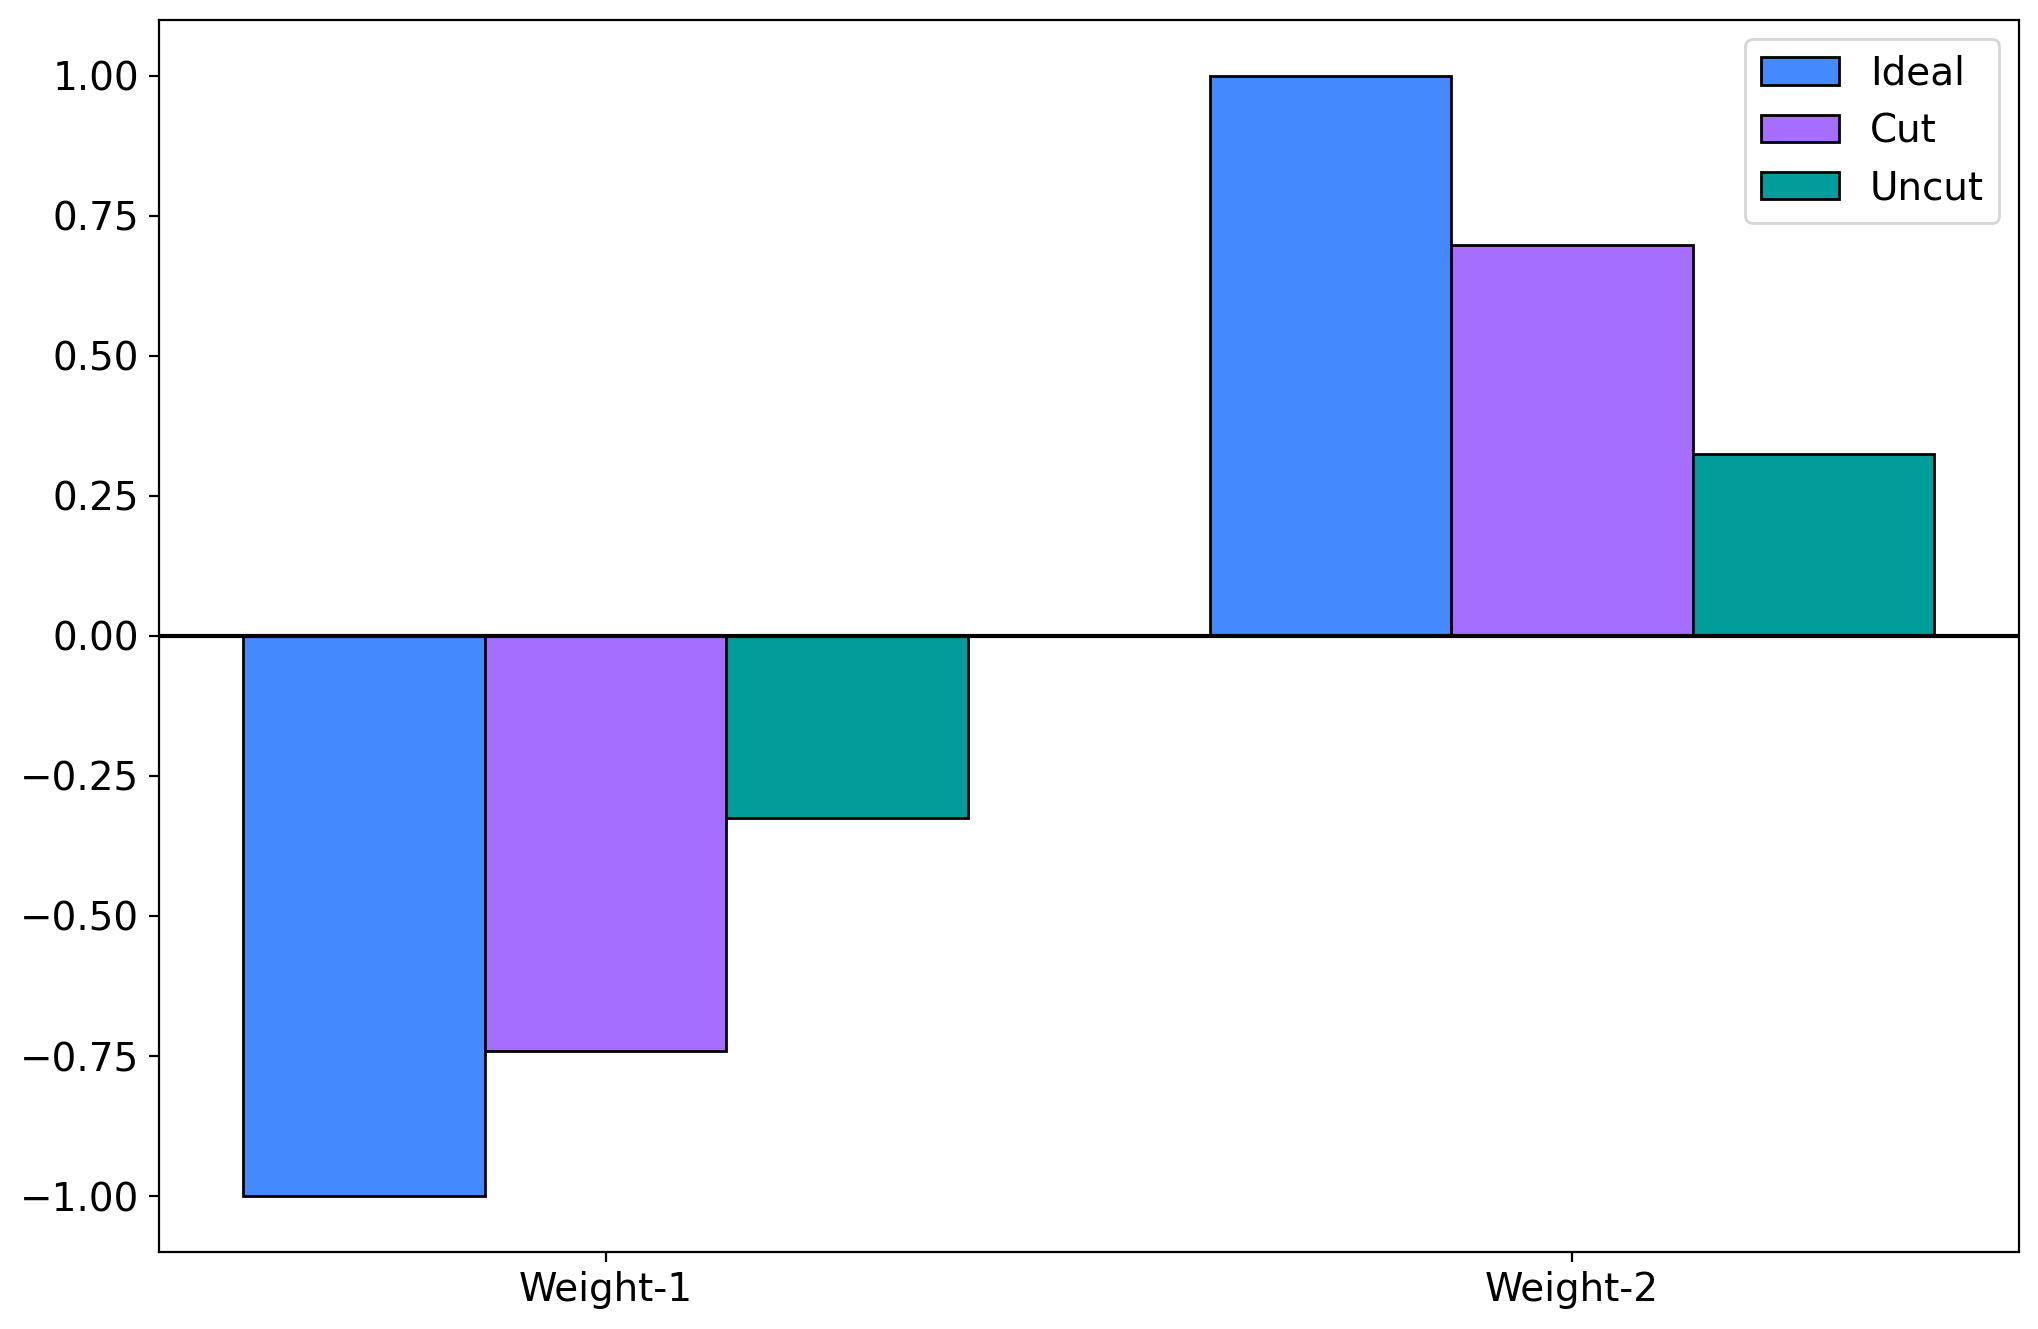

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

fig = plt.subplots(figsize=(12, 8), dpi=200)
width = 0.25
labels = ["Weight-1", "Weight-2"]
x = np.arange(len(labels))

ideal = [-1, 1]
cut = [cut_weight_1, cut_weight_2]
uncut = [uncut_weight_1, uncut_weight_2]

br1 = np.arange(len(ideal))
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]

plt.bar(
    br1, ideal, width=width, edgecolor="k", label="Ideal", color="#4589ff"
)
plt.bar(br2, cut, width=width, edgecolor="k", label="Cut", color="#a56eff")
plt.bar(
    br3, uncut, width=width, edgecolor="k", label="Uncut", color="#009d9a"
)

plt.axhline(y=0, color="k", linestyle="-")

plt.xticks([r + width for r in range(len(ideal))], labels, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.show()

### Summary

In summary, we calculated the average expectation values of weight-1 and weight-2 Z-types observables for a periodic 1D chain of 109 qubits. In order to do so, we

- created a virtual coupling map by adding a long range connectivity between the first and the last qubits of the 1D chain, and transpiled the circuit.
    - transpilation at this stage allowed us to avoid the overhead of transpiling each subexperiment separately after cutting,
    - using virtual coupling map allowed us to avoid extra SWAP gates for the 2-qubit operation between the first and the last qubits.
- removed the long range connectivity from the transpiled circuit via gate cutting.
- converted the cut circuits into basis gate set by applying appropriate transpilation passes.
- executed the cut circuits on IBM Quantum device using a `SamplerV2` primitive.
- obtained the expectation value by reconstructing the outcomes of the cut circuits.

### Inference

We notice from the results that the average of the weight-1 $\langle Z \rangle$ and weight-2 $\langle ZZ \rangle$ type observables are significantly improved by cutting the periodic gates. Note that this study does not include any error suppression or mitigation techniques. The improvement observed is solely due to the proper usage of gate cutting for this problem. The results could have been further improved by using the mitigation and suppression techniques.

This study shows an example of effectively using gate cutting to improve the performance of computation.

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3fQQYAIjTxvIChg)